# TP3: Image reconstruction in X-ray Tomography

### Anne GAGNEUX, Clémence GRISLAIN

## 1. X-RAY Tomography

1. Download data

In [1]:
from scipy.io import loadmat
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import trange
from time import time
from scipy.sparse.linalg import svds

NMAX = 10000

In [2]:
H = loadmat("data/H.mat")
x = loadmat("data/x.mat")

print("Dimensions")
print("Projection matrix:", H['H'].shape)
print("Absobtion signal:", x['x'].shape)

Dimensions
Projection matrix: (16200, 8100)
Absobtion signal: (8100, 1)


2. Construct measured signal

In [3]:
sigma = 1
w = np.random.normal(0,sigma**2, size = (H['H'].shape[0],1) )
y = H['H'] @ x['x'] 

3. Display signals as images

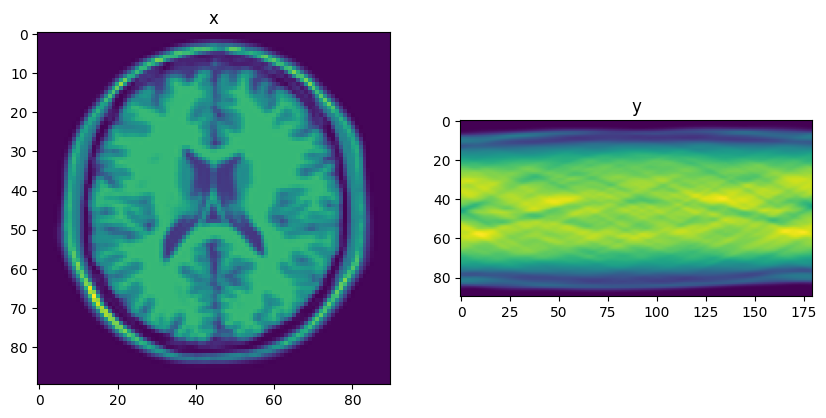

In [4]:
fig = plt.figure(figsize=(10,5))

fig.add_subplot(1,2,1)
plt.imshow(x['x'].reshape((90,90), order = 'F'))
plt.title("x")

fig.add_subplot(1,2,2)
plt.imshow(y.reshape((90,180), order = 'F'))
plt.title("y")

plt.show()

## 2. Optimization problem

1. Download data

In [5]:
G = loadmat("data/G.mat")
lambd, delta = 0.13, 0.02

*2. Give the expression of the gradient ∇f at some point x ∈ RN. Create a function which gives as an output the gradient of f at some input vector x.*

We first need to calculate $\textbf{Jac } r(x)$.

$\frac{\delta r}{\delta x_j} = \sum_{i} \frac{\delta [Gx]^i}{\delta x_j} \dot \psi ([Gx]^i)  = \sum_{i} G_{ij} \dot \psi ([Gx]^i) $

$\nabla r(x) = \textbf{Jac }^T r(x)   = G^T \left( \dot \psi ([Gx]^i) \right)_i $

with $\dot \psi (u)  = \frac{u}{\delta^2 \sqrt{1+\frac{u^2}{\delta^2}}}$
$$ \nabla f(x) = H^T (Hx-y) + \lambda   G^T \left( \dot \psi ([Gx]^i) \right)_i $$ 

In [6]:
def psi(u):
    return np.sqrt(1+(np.multiply(u,u)/delta**2))
    
def gradient_psi(u):
    return u/ (delta**2 * np.sqrt(1+(np.multiply(u,u)/delta**2)))


def gradient_f(x):
    return H['H'].T @ (H['H']@x-y) + lambd * (G['G'].T @   gradient_psi(G['G'] @ x))

def w(u):
    return 1./ (delta**2 * np.sqrt(1+(np.multiply(u,u)/delta**2)))

In [7]:
class OptimizationAlgorithm():
    def __init__(self):
        self.x = None
        
    def quadratic_error(self):
        return np.linalg.norm(self.x-x['x'])
    
    def f(self):
        return 0.5 * np.linalg.norm((H['H'] @ self.x)-y)**2 + lambd * psi(G['G'] @ self.x).sum()

*3. Show the Lipschitz constant of $\nabla f$.*

we'll show tha the Hessian matrix $\nabla^2 f$ is bounded. 

$$ ||\nabla^2 f(x)||^2= || H^T H + \lambda G^T D_{x} \left( \dot \psi ([Gx]^i)_i \right) ||_2^2$$



We have 

$$ \ddot \psi (u) = \frac{1}{\delta^2 (1+\frac{u^2}{\delta^2})^{\frac{3}{2}}} $$

and we get:

$$\frac{\delta \dot \psi [Gx]^i}{\delta x_j} = \frac{\delta}{\delta x_j}  \left[ \frac{\sum_k G_{ik} x_k}{\sqrt{1+\frac{\left(\sum_k G_{ik} x_k\right)^2}{\delta^2}}} \right]  = G_{ij}\frac{1}{\delta^2 (1+\frac{\left(\sum_k G_{ik} x_k\right)^2}{\delta^2})^{\frac{3}{2}}} $$

So:

$$ D_{x} \left( \dot \psi ([Gx]^i) \right)_i  = \left[ G_{ij} \frac{1}{\delta^2 (1+\frac{\left(\sum_k G_{ik} x_k\right)^2}{\delta^2})^{\frac{3}{2}}} \right]_{ij} = \frac{1}{\delta^2}  \text{ diag} \left( \frac{1}{(1+\frac{\left(\sum_k G_{ik} x_k\right)^2}{\delta^2})^{\frac{3}{2}}} \right)_i  G$$

$$ ||\nabla^2 f(x)|| = || H^T H + \frac{\lambda}{\delta^2} G^T  \text{ diag} \left( \frac{1}{(1+\frac{\left(\sum_k G_{ik} x_k\right)^2}{\delta^2})^{\frac{3}{2}}} \right)_i G ||^2$$

$$\leq ||H^T|| ||H|| + \frac{\lambda}{\delta^2}||G^T||||G|| \max_i \left( \frac{1}{(1+\frac{\left(\sum_k G_{ik} x_k\right)^2}{\delta^2})^{\frac{3}{2}}} \right)_i   $$

And as $\forall A ||A^T|| = ||A||$ if we choose the spectral norm. 

So we get the following inequality:

$$\leq ||H||^2 + \frac{\lambda}{\delta^2}||G||^2 \max_i \left( \frac{1}{(1+\frac{\left(\sum_k G_{ik} x_k\right)^2}{\delta^2})^{\frac{3}{2}}} \right)_i   $$

And we also have directly $\left( \frac{1}{(1+\frac{\left(\sum_k G_{ik} x_k\right)^2}{\delta^2})^{\frac{3}{2}}} \right)_i  \leq 1 \forall i$.

So we finally get the following Lipschitzian constant:

$$ L = ||H||^2 + \frac{\lambda}{\delta^2}||G||^2 $$

In [8]:
norm_H = svds(H['H'],1)[1][0]
norm_G = svds(G['G'],1)[1][0]
L = norm_H**2 + lambd / delta**2 * norm_G**2
print("L:", L)

L: 18092.773276864813


## 3. Optimization algorithms

### 3.1 Gradient descent algorithm

In [9]:
N = 90*90

class GradientDescentAlgorithm(OptimizationAlgorithm):
    def __init__(self,grad, x0 = np.zeros((N,1)), gamma= 0.0001):
        self.x = np.copy(x0)
        self.grad = grad
        self.gamma = gamma 
        self.nstep = 0
        self.errors = []
        self.f_values = []
        self.time = []
    
    def step(self):
        self.x = self.x - self.gamma * self.grad(self.x)
    
    def train(self, n = NMAX):
        
        for i in trange(n):
            start = time()
            self.step()
            
            if i>0: self.time.append(self.time[-1]+time()-start)
            else: self.time.append(time()-start)

            self.errors.append(self.quadratic_error())
            self.f_values.append(self.f())
            self.nstep += 1

            if np.linalg.norm(self.grad(self.x)) <= np.sqrt(N)*10**(-4): break

In [10]:
GDA = GradientDescentAlgorithm(gradient_f)

In [11]:
GDA.train()

 28%|█████████████████████████████████████████████▊                                                                                                                    | 2829/10000 [00:36<01:32, 77.69it/s]


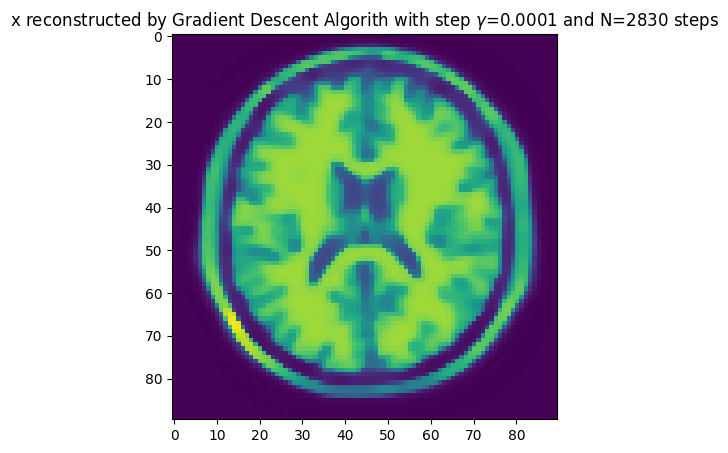

In [12]:
fig = plt.figure(figsize=(10,5))

plt.imshow(GDA.x.reshape((90,90), order = 'F'))
plt.title("x reconstructed by Gradient Descent Algorith with step $\gamma$={} and N={} steps".format(GDA.gamma,  GDA.nstep))

plt.show()

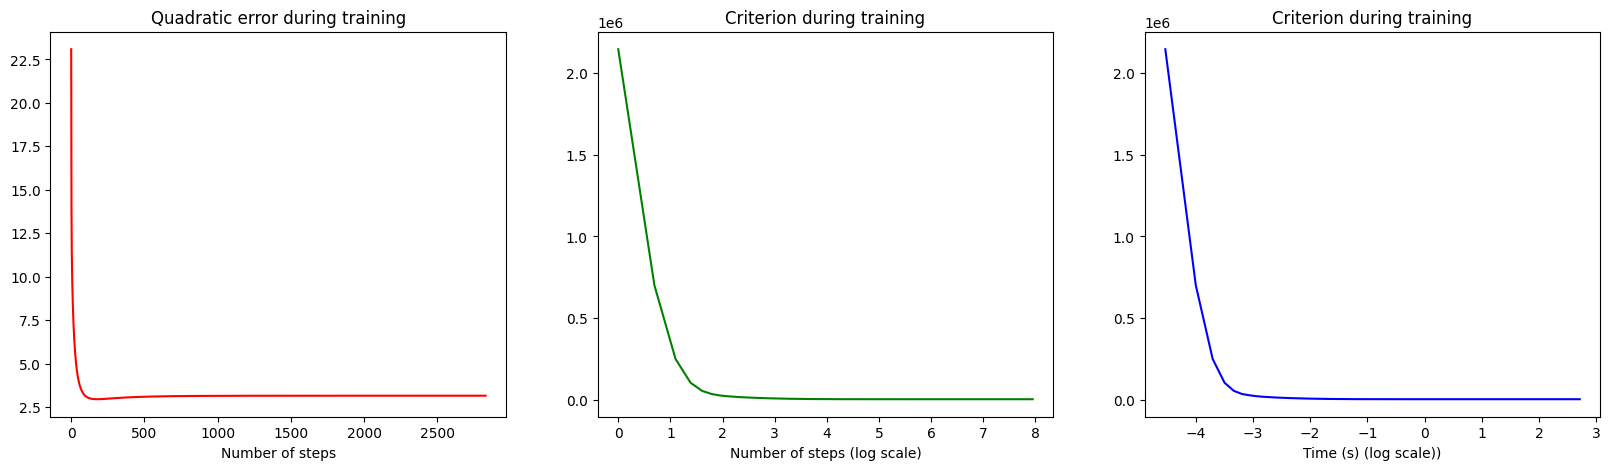

In [14]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,3,1)
plt.plot(range(GDA.nstep), GDA.errors, c='r')
plt.xlabel("Number of steps")
plt.title("Quadratic error during training")

fig.add_subplot(1,3,2)
plt.plot(np.log(np.linspace(1,GDA.nstep+1, GDA.nstep)), GDA.f_values, c='g')
plt.xlabel("Number of steps (log scale)")
plt.title("Criterion during training")

fig.add_subplot(1,3,3)
plt.plot(np.log(GDA.time), GDA.f_values, c = 'b')
plt.xlabel("Time (s) (log scale))")
plt.title("Criterion during training")

plt.show()

In [25]:
print('\033[1m' + "Gradient Descent Algorithm")
print('\033[0m' + "Computation time: {}s".format(round(GDA.time[-1], 2)))
print("Number of iterations:", GDA.nstep)

Gradient Descent Algorithm
Computation time: 15.04s
Number of iterations: 2830


### 3.2 MM quadratic algorithm

$$ f(x) = f(z) + (\nabla f(z)|x-z) + \frac{1}{2} (x-z | \nabla^2f(z) (x-z)) + \frac{1}{3!} D^3(f)_z [x-z]^3 o(||x-z||^3) $$


Let's write $f(x) = g(x) + \lambda r(x)$.
We have $g(x) = \frac{1}{2} ||Hx-y||^2$ quadratic so $D^3(g)_z = 0$ and we have the majoration by $\nabla^2g(z)=H^tH$.

For $r(x)$: we have $\psi$ convex so we know we have the following quadratic majoration on $\psi$:

$ \psi(u) \leq \psi(v) +\dot \psi(u) (u-v) + \frac{1}{2} A(u)(u-v)^2 \forall u,v$ with $A(u) \text{ st. } A(u) - \ddot \psi(u) \geq 0 \forall u$.
We can take $A(u) = w(u) = \frac{1}{\delta^2} \frac{1}{\sqrt{1+u^2 / \delta^2}} = \frac{\dot \psi(u)}{1+u^2 / \delta^2} \geq \dot \psi(u)$

We have, by applying this inequality on each component of the vectors $Gx$ and $Gz$:

$$r(x) = \sum_n \psi [Gx]_n \leq  \sum_n \left(\psi [Gz]_n + \dot \psi [Gx]_n [G(z-x)]_n +  \frac{1}{2} w[Gx]_n \left([G(z-x)]_n\right)^2 \right)$$

$$ = r(z) +(\dot \psi [Gx]|G(z-x) ) + \frac{1}{2} \left(G(z-x)\right)^T \cdot diag\left( (w[Gx]_n)_n \right) \cdot G(z-x) $$

$$ = r(z) +(z-x)^T \left(\psi [Gx] ^T G\right)+ \frac{1}{2} (z-x)^T \left(G^T \cdot diag\left( (w[Gx]_n)_n \right) \cdot G \right ) (z-x) $$ 

We have  $\psi [Gx] ^T G = \nabla r_x $ and so we have the quadratic majoration on $r$ with $A_r(x) = G^T \cdot diag\left( (w[Gx]_n)_n \right) \cdot G$.

By assembling majoration on $g$ and $r$, we get the quadratic majoration on $f$  with $A_f(x) = \nabla^2g(x) +A_r(x) = H^tH + G^T \cdot diag\left( (w[Gx]_n)_n \right) \cdot G $.

In [16]:
M = 90 * 180
def compute_A(x): 
    x = x.flatten()
    def curv(v):
        return H['H'].T @ (H['H'] @ v) + lambd  * (G['G'].T  @  (sp.sparse.diags(w(G['G'] @ x).flatten()).tocsc() @ (G['G'] @ v)))
    return sp.sparse.linalg.LinearOperator(shape=(N,N), matvec = curv, rmatvec = curv)


In [17]:
class MMQuatraticAlgorithm(OptimizationAlgorithm):
    def __init__(self,grad, A , x0 = np.zeros((N,1)), theta0= 1):
        self.x = np.copy(x0)
        self.grad = grad
        self.A = A
        self.theta = theta0 
        self.nstep = 0
        self.errors = []
        self.f_values = [self.f()]
        self.time = [0]
    
    def step(self):
        A = self.A(self.x)
        grad = self.grad(self.x)
        self.x = self.x - self.theta * sp.sparse.linalg.bicg(A ,grad )[0].reshape(self.x.shape)
    

    def train(self, n=NMAX):
        for i in trange(n):
            start = time()
            self.step()
            self.time.append(self.time[-1]+time()-start)
            self.errors.append(self.quadratic_error())
            self.f_values.append(self.f())
            self.nstep+=1
            if np.linalg.norm(self.grad(self.x)) <= np.sqrt(N)*10**(-4): break

In [18]:
MM = MMQuatraticAlgorithm(grad = gradient_f, A = compute_A)

In [19]:
MM.train()

  1%|█                                                                                                                                                                 | 69/10000 [00:26<1:03:07,  2.62it/s]


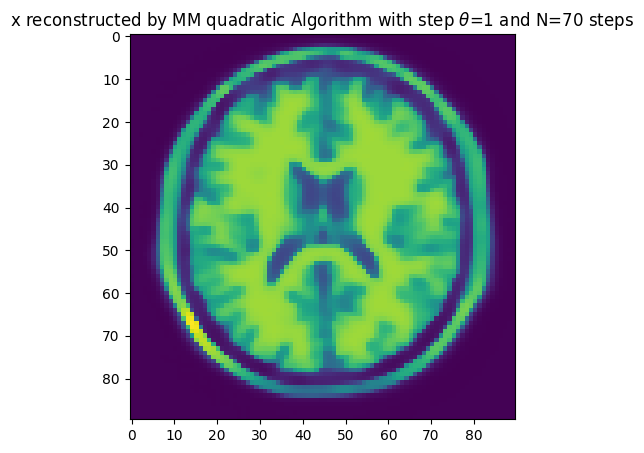

In [20]:
fig = plt.figure(figsize=(10,5))

plt.imshow(MM.x.reshape((90,90), order = 'F'))
plt.title("x reconstructed by MM quadratic Algorithm with step $\\theta$={} and N={} steps".format(MM.theta,  MM.nstep))

plt.show()

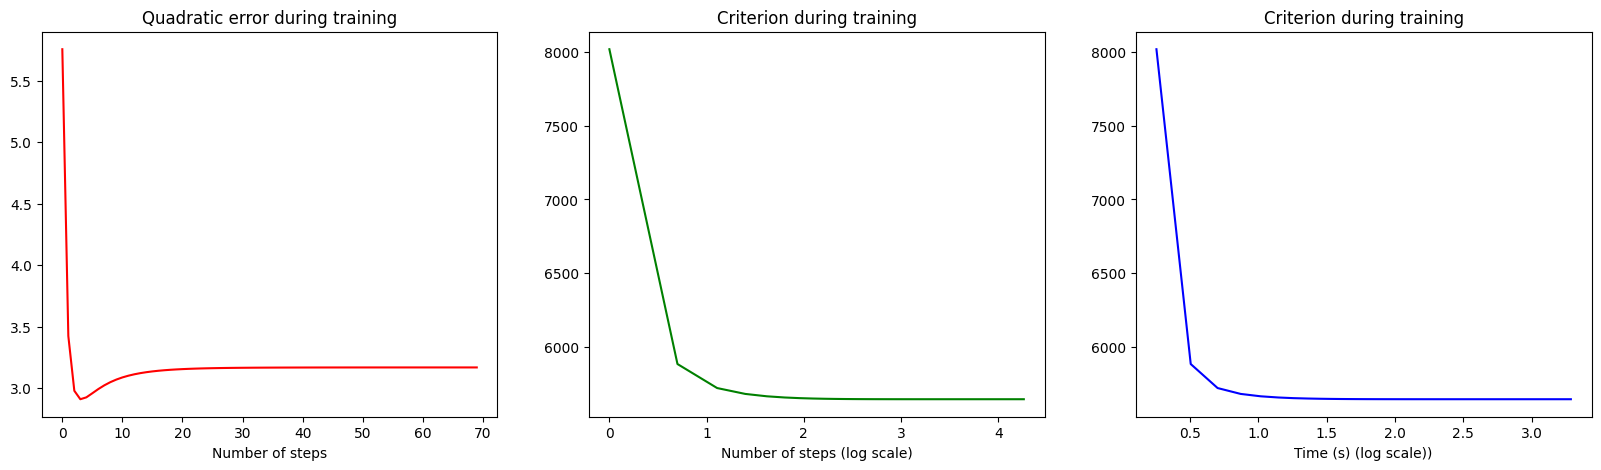

In [38]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,3,1)
plt.plot(range(MM.nstep), MM.errors, c='r')
plt.xlabel("Number of steps")
plt.title("Quadratic error during training")

fig.add_subplot(1,3,2)
plt.plot(np.log(np.linspace(1,MM.nstep+1, MM.nstep)), MM.f_values[1:], c='g')
plt.xlabel("Number of steps (log scale)")
plt.title("Criterion during training")

fig.add_subplot(1,3,3)
plt.plot(np.log(MM.time)[1:], MM.f_values[1:], c = 'b')
plt.xlabel("Time (s) (log scale))")
plt.title("Criterion during training")

plt.show()

In [39]:
print('\033[1m' + "MM quadratic Algorithm")
print('\033[0m' + "Computation time: {}s".format(round(MM.time[-1], 2)))
print("Number of iterations:", MM.nstep)

MM quadratic Algorithm
Computation time: 26.77s
Number of iterations: 70


### 3.3 3MG Algorithm

In [40]:
class MMMemoryGradientAlgorithm(OptimizationAlgorithm):
    def __init__(self, grad, A ,  x0 = np.zeros((N,1)), theta0= 0.8):
        self.x = np.copy(x0)
        self.grad = grad
        self.A = A
        self.theta = theta0 
        self.nstep = 0
        self.errors = []
        self.f_values = []
        self.time = []
    
    def D(self):
        return np.concatenate((-self.grad(self.x), self.x-self.x_prev), axis=1)
    
    def step(self,i):
        if i>0:
            Dk = self.D()
        else:
            Dk = -self.grad(self.x)
        hd = (H['H'] @ Dk )
        gd = (G['G'] @ Dk)
        dgrad = Dk.T @ self.grad(self.x)
        A_proj = hd.T @ hd + lambd * gd.T @ (sp.sparse.diags(w(G['G'] @ self.x.flatten()).flatten()).tocsc() @ gd)
        inv = sp.linalg.pinv(A_proj)
        uk = - inv @ dgrad 
        self.x_prev = self.x
        self.x = self.x + Dk @ uk
    
    def train(self, n = NMAX):
        for i in trange(n):
            start = time()
            self.step(i)
            
            if i>0: self.time.append(self.time[-1]+time()-start)
            else: self.time.append(time()-start)

            self.errors.append(self.quadratic_error())
            self.f_values.append(self.f())
            self.nstep+=1

            if np.linalg.norm(self.grad(self.x)) <= np.sqrt(N)*10**(-4): break

In [41]:
ThreeMM = MMMemoryGradientAlgorithm(gradient_f, A = compute_A)

In [42]:
ThreeMM.train()

  1%|██▎                                                                                                                                                                | 145/10000 [00:05<06:37, 24.80it/s]


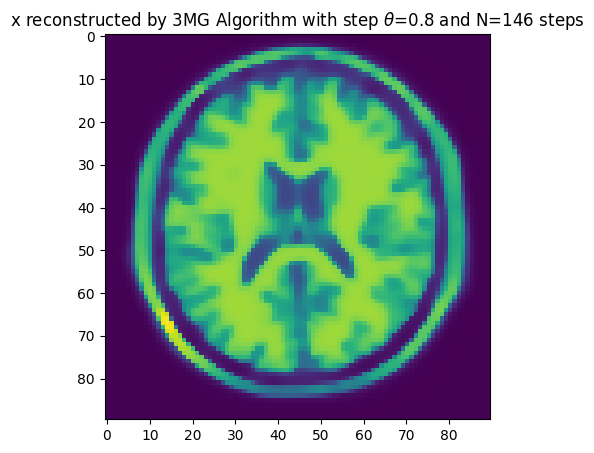

In [43]:
fig = plt.figure(figsize=(10,5))

plt.imshow(ThreeMM.x.reshape((90,90), order = 'F'))
plt.title("x reconstructed by 3MG Algorithm with step $\\theta$={} and N={} steps".format(ThreeMM.theta,  ThreeMM.nstep))

plt.show()

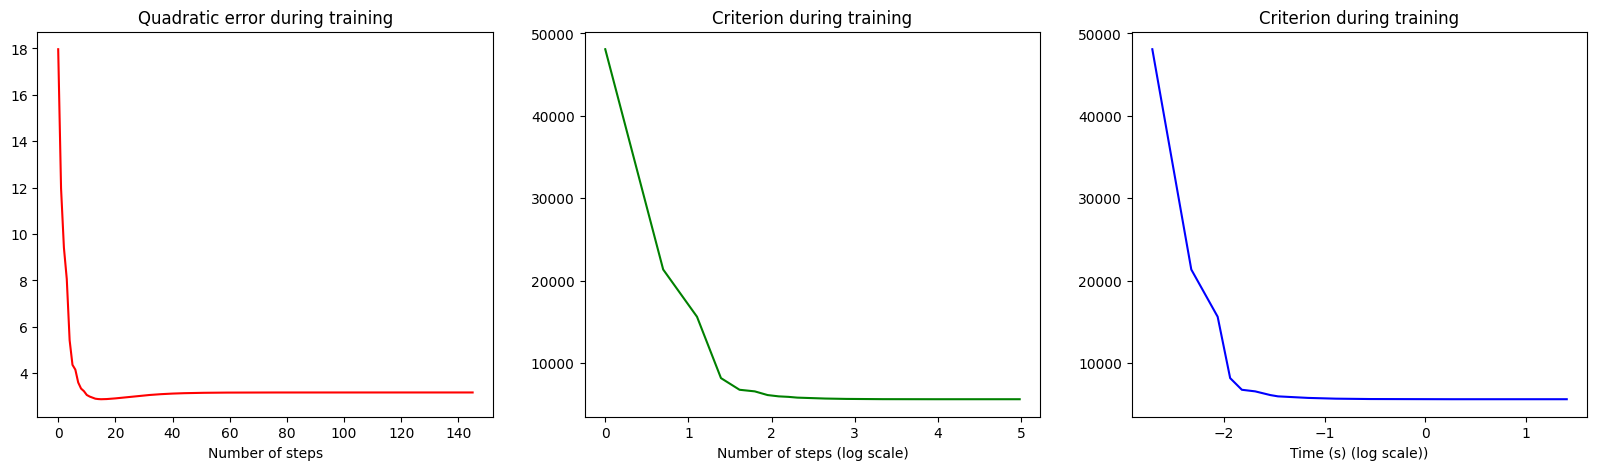

In [47]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,3,1)
plt.plot(range(ThreeMM.nstep), ThreeMM.errors, c='r')
plt.xlabel("Number of steps")
plt.title("Quadratic error during training")

fig.add_subplot(1,3,2)
plt.plot(np.log(np.linspace(1,ThreeMM.nstep, ThreeMM.nstep-1)), ThreeMM.f_values[1:], c='g')
plt.xlabel("Number of steps (log scale)")
plt.title("Criterion during training")

fig.add_subplot(1,3,3)
plt.plot(np.log(ThreeMM.time)[1:], ThreeMM.f_values[1:], c = 'b')
plt.xlabel("Time (s) (log scale))")
plt.title("Criterion during training")

plt.show()

In [48]:
print('\033[1m' + "3MG quadratict Algorithm")
print('\033[0m' + "Computation time: {}s".format(round(ThreeMM.time[-1], 2)))
print("Number of iterations:", ThreeMM.nstep)

3MG quadratict Algorithm
Computation time: 4.08s
Number of iterations: 146


### 3.4 Block-coordinate MM quadratic algorithm

In [49]:
def A_j(x,J): 
    x = x.flatten()
    Hj = H['H'][:,J]
    Gj = G['G'][:,J]
    def curv(v):
        return Hj.T @ (Hj @ v) + lambd  * (Gj.T @  (sp.sparse.diags(w(G['G'] @ x).flatten()).tocsc() @ (Gj @ v)))
    return sp.sparse.linalg.LinearOperator(shape=(len(J),len(J)), matvec = curv, rmatvec = curv)

def J(N_blocks,j):
    return np.array(range(N_blocks[j-1]*(j-1), j*N_blocks[j-1]))

In [50]:
class BlockMMQuadraticAlgorithm(OptimizationAlgorithm):
    def __init__(self,grad, A , N_blocks, x0 = np.zeros((N,1)), theta0= 1):
        self.x = np.copy(x0)
        self.grad = grad
        self.A = A
        self.N_blocks = N_blocks
        self.nstep = 0
        self.theta = theta0 
        self.errors = []
        self.f_values = []
        self.time = []
    
    def step(self,i):
        indexes = J(self.N_blocks,(i-1)%len(self.N_blocks)+1)
        A = self.A(self.x, indexes)
        grad = self.grad(self.x)[indexes]
        self.x[indexes] -= self.theta * sp.sparse.linalg.bicg(A, grad )[0].reshape(self.x[indexes].shape)
    
    def train(self, n = NMAX):
        for i in trange(n):
            start = time()
            self.step(i)
            
            if i>0: self.time.append(self.time[-1]+time()-start)
            else: self.time.append(time()-start)

            self.errors.append(self.quadratic_error())
            self.f_values.append(self.f())
            self.nstep+=1

            if np.linalg.norm(self.grad(self.x)) <= np.sqrt(N)*10**(-4): break

In [51]:
steps = []
t_BlockMM = []
f_BlockMM = []
N = 90*90
Ktests = [1,2,3,5,6,9]
for K in Ktests:
    BMM = BlockMMQuadraticAlgorithm(grad = gradient_f, A = A_j, N_blocks = [int(N/K) for k in range(K)])
    BMM.train()
    t_BlockMM.append(BMM.time)
    f_BlockMM.append(BMM.f_values)
    steps.append(BMM.nstep)

  7%|███████████▎                                                                                                                                                       | 692/10000 [00:39<08:51, 17.51it/s]


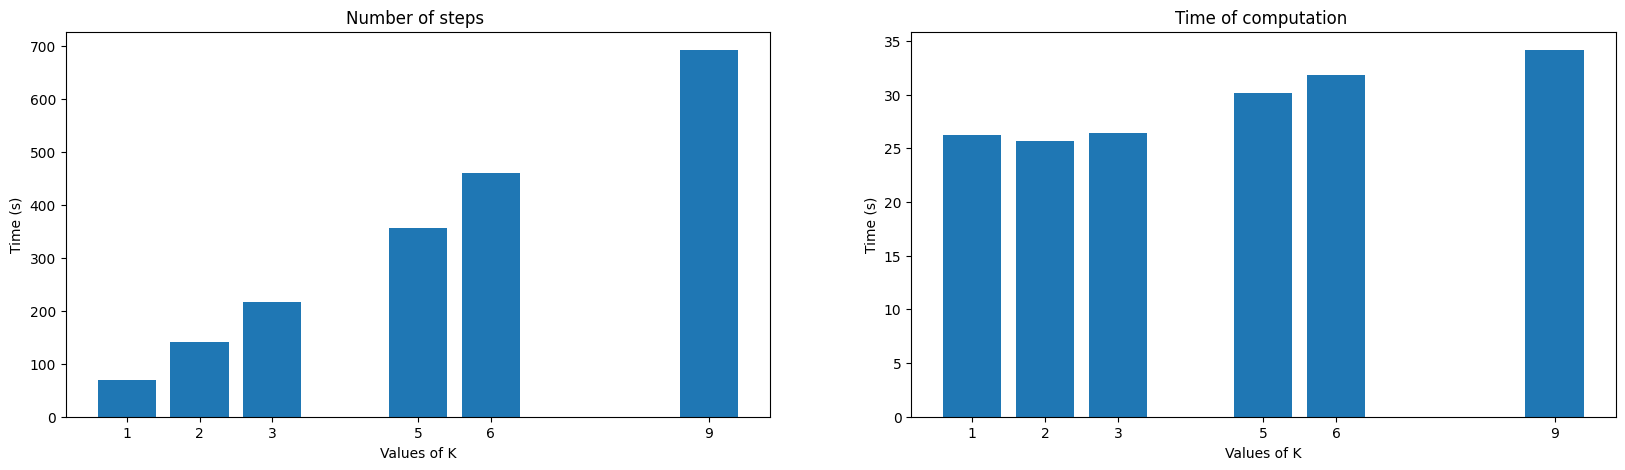

In [52]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,2,1)
plt.bar(Ktests, steps)
plt.xticks(Ktests)
plt.xlabel("Values of K")
plt.ylabel("Time (s)")
plt.title("Number of steps ")

fig.add_subplot(1,2,2)
plt.bar(Ktests, [t_BlockMM[k][-1] for k in range(6)])
plt.xticks(Ktests)
plt.ylabel("Time (s)")
plt.xlabel("Values of K")
plt.title("Time of computation ")

plt.show()

### 3.4 Parallel MM quadratic algorithm

1. 

Jensen inequality gives for every convex function $g$ that:

$$\forall (x_i)_i, \forall (w_i) \text{ st. } \sum w_i = 1, w_i \geq 0 $$ 

$$ g(\sum_{p=1}^P w_i x_i) \leq \sum_{p=1}^P w_i g(x_i) $$ 

Let's recall $A(x)$:

$$ A(x) = H^TH + \lambda G^T w(Gx) G $$. 

We're going to majorate separately each part of $A$.

- First, let's show that  $H^TH \leq diag(\mathcal H^T_i \mathbb 1)$ 

We use the operator norm: $||A|| = \max_{x \text{ st. } ||x||=1} ||Ax||_2$. 

We have, as the operator norm is submultiplicative:

$$||H^TH||^2 \leq ||H||^4  $$

Then,  we can write , for $x \in \mathbb R^n$:

\begin{equation} 
\begin{split}
||Hx||^2_2 & = \sum_m \left(\sum_n H_{mn} x_n \right)^2 \\
 & = \sum_m \left(\sum_n \frac{|H_{mn}|}{\sum_p |H_{mp}|} \times \sum_p |H_{mp}| \times \frac{H_{mn}}{|H_{mn}|} x_n \right)^2
\end{split}
\end{equation}

The, we apply Jensen inequality with $w_n = \frac{|H_{mn}|}{\sum_p |H_{mp}|}$ and the convex function $x \mapsto x^2$:

\begin{equation} 
\begin{split}
||Hx||^2_2 & \geq \sum_m \sum_n \frac{|H_{mn}|}{\sum_p |H_{mp}|} \times \left(\sum_p |H_{mp}|\right)^2 \times \left(\frac{H_{mn}}{|H_{mn}|} x_n \right)^2 \\
 &  = \sum_m \sum_n \frac{|H_{mn}|}{\sum_p |H_{mp}|} \times \left(\sum_p |H_{mp}|\right)^2 \times x_n^2 \\
 & = \sum_m \sum_n |H_{mn}|\sum_p |H_{mp}| x_n^2
\end{split}
\end{equation}

Then we compute:

$$||Hx||^4_2  \leq \left(\sum_n  x_n^2 \sum_m |H_{mn}|\sum_p |H_{mp}| \right)^2$$

And we can apply Jensen a second time on $w_n=x_n$ as $||x||=1 \iff \sum x_n^2 =1$:

$$||Hx||^4_2 \leq \sum_n  x_n^2 (\sum_m |H_{mn}|\sum_p |H_{mp}|)^2 = ||\mathcal H^T \mathbb 1 x||_2^2$$

So we have:

$$||H^TH|| \leq  ||diag(\mathcal H^T_i \mathbb 1)||$$


We have still to show the other part of the inequality and then with Cauchy Schwartz, we will be able to combine them to obtain $A\leq B$

In [58]:
def b_inv(x):
    abs_H = abs(H['H'])
    abs_G = abs(G['G'])
    b1 = abs_H.multiply(abs_H.sum(axis=1)).sum(axis=0).T
    b2 = abs_G.multiply(abs_G.sum(axis=1)).T @ w(G['G'] @ x)
    return np.array(1./(b1 + lambd * b2))

In [62]:
class ParallelMMQuadraticAlgorithm(OptimizationAlgorithm):
    def __init__(self, grad ,x0 = np.zeros((N,1)), theta0= 1.1):
        self.x = np.copy(x0)
        self.nstep = 0
        self.grad = grad
        self.theta = theta0 
        self.errors = []
        self.f_values = []
        self.time = []
    
    def step(self,i):
        binv = b_inv(self.x)
        self.x = self.x - self.theta * (binv * self.grad(self.x)).reshape(self.x.shape)
     
    def quadratic_error(self):
        return np.linalg.norm(self.x-x['x'])
    
    def train(self, n= NMAX):
        for i in trange(n):
            start = time()
            self.step(i)
            
            if i>0: self.time.append(self.time[-1]+time()-start)
            else: self.time.append(time()-start)

            self.errors.append(self.quadratic_error())
            self.f_values.append(self.f())
            self.nstep+=1

            if np.linalg.norm(self.grad(self.x)) <= np.sqrt(N)*10**(-4): break

In [63]:
PMM = ParallelMMQuadraticAlgorithm(gradient_f)

In [64]:
PMM.train()

 40%|████████████████████████████████████████████████████████████████▏                                                                                                 | 3962/10000 [03:31<05:21, 18.78it/s]


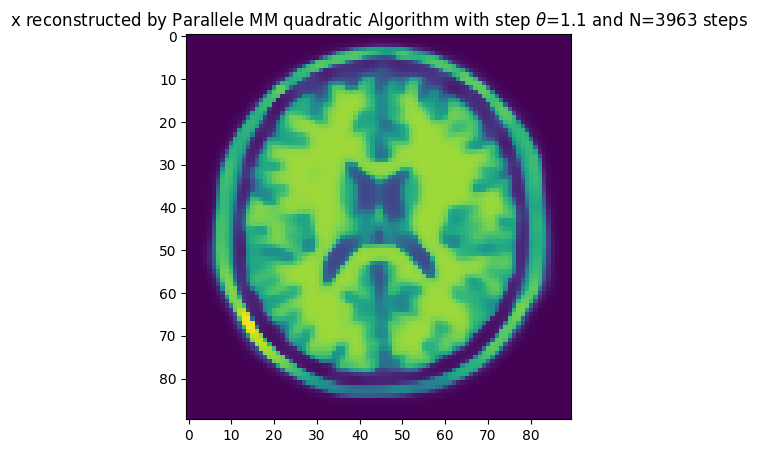

In [65]:
fig = plt.figure(figsize=(10,5))

plt.imshow(PMM.x.reshape((90,90), order = 'F'))
plt.title("x reconstructed by Parallele MM quadratic Algorithm with step $\\theta$={} and N={} steps".format(PMM.theta,  PMM.nstep))

plt.show()

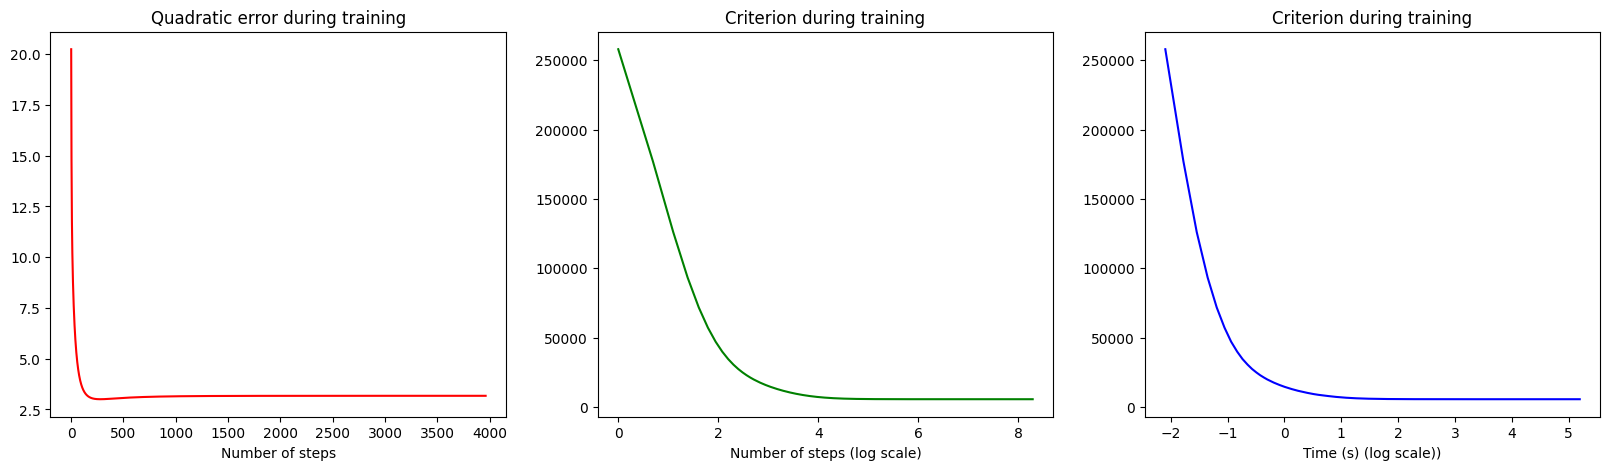

In [67]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,3,1)
plt.plot(range(PMM.nstep), PMM.errors, c='r')
plt.xlabel("Number of steps")
plt.title("Quadratic error during training")

fig.add_subplot(1,3,2)
plt.plot(np.log(np.linspace(1,PMM.nstep, PMM.nstep-1)), PMM.f_values[1:], c='g')
plt.xlabel("Number of steps (log scale)")
plt.title("Criterion during training")

fig.add_subplot(1,3,3)
plt.plot(np.log(PMM.time)[1:], PMM.f_values[1:], c = 'b')
plt.xlabel("Time (s) (log scale))")
plt.title("Criterion during training")

plt.show()

In [68]:
print('\033[1m' + "Parallele MM quadratict Algorithm")
print('\033[0m' + "Computation time: {}s".format(round(PMM.time[-1], 2)))
print("Number of iterations:", PMM.nstep)

Parallele MM quadratict Algorithm
Computation time: 180.32s
Number of iterations: 3963


This algorithm should use multiple CPU cores to allow faster computation. As we do not have such hardware we lauch it on a simple CPU core and iterate the parallel operations. As a consequence, the computation time is really high but this does not represent the real benefit of this algorithm.

### 3.6 Comparison of the methods

Text(0.5, 1.0, 'Time of computation ')

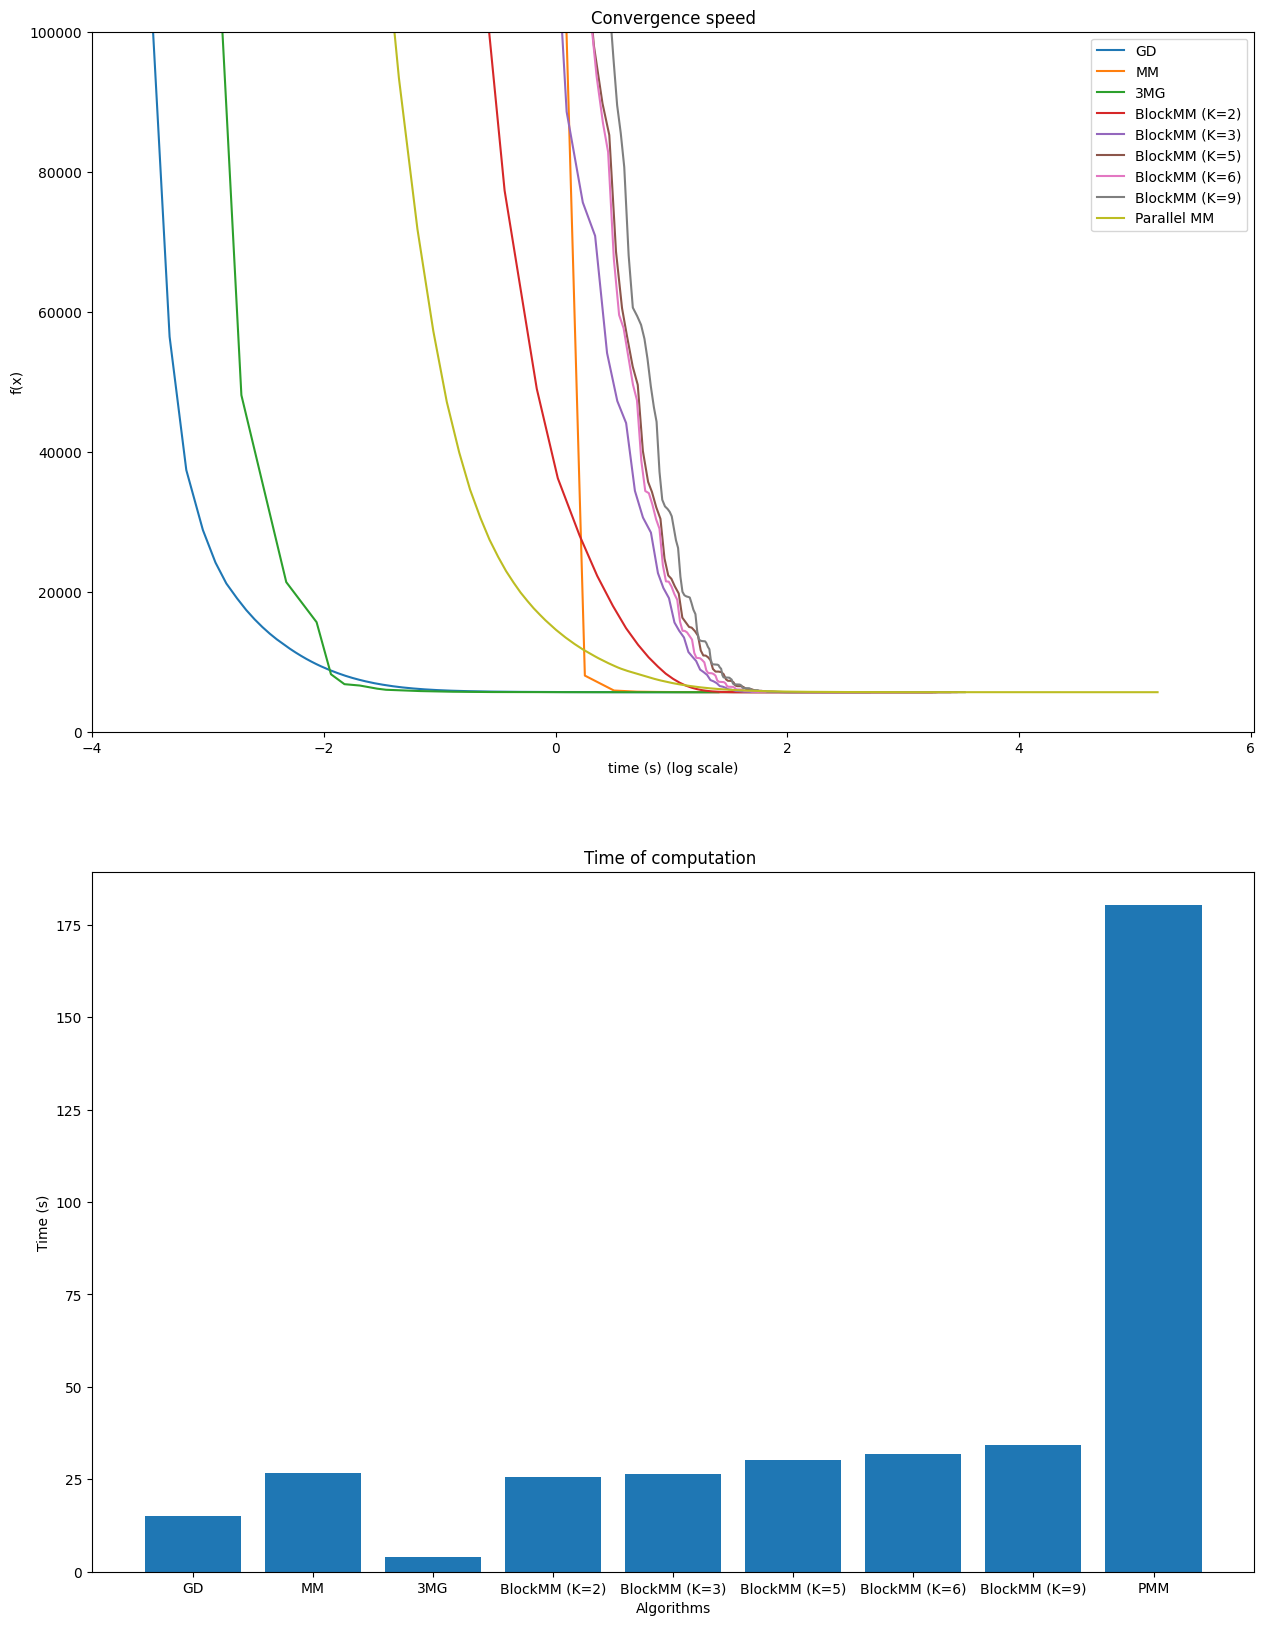

In [70]:
fig = plt.figure(figsize=(15,20))

fig.add_subplot(2,1,1)
plt.plot(np.log(GDA.time), GDA.f_values, label="GD")
MM.time[0]=0.00001
plt.plot(np.log(MM.time), MM.f_values, label="MM")
plt.plot(np.log(ThreeMM.time), ThreeMM.f_values, label="3MG")
for K in range(1, 6):
    plt.plot(np.log(t_BlockMM[K]), f_BlockMM[K], label="BlockMM (K={})".format(Ktests[K]))
plt.plot(np.log(PMM.time), PMM.f_values, label="Parallel MM")
plt.xlim(left=-4)
plt.xlabel('time (s) (log scale)')
plt.ylabel('f(x)')
plt.title("Convergence speed")
plt.ylim(0, 100000)
plt.legend()

fig.add_subplot(2,1,2)
algos = ["GD", "MM", "3MG"]
times = [GDA.time[-1], MM.time[-1], ThreeMM.time[-1]]
for K in range(1, 6):
    algos.append("BlockMM (K={})".format(Ktests[K]))
    times.append(t_BlockMM[K][-1])
algos.append("PMM")
times.append(PMM.time[-1])

plt.bar(algos, times)
plt.xticks(algos)
plt.xlabel("Algorithms")
plt.ylabel("Time (s)")
plt.title("Time of computation ")

We can note two sets of algorithm:

* early convergence: GM, MM, 3GM
* late convergence: BlockMM $(\forall K)$, parallel MM

However, the stopping criterion can be reach long after the convergence is set.

3. Search for parameters $(\lambda, \delta)$

The faster algorithm is the 3MG. 

We look for the best parameters $\lambda$, $\delta$ that maximize the PSNR measure: $$ SNR = 10\times log_{10}\left( \frac{||x||^2}{||x - \hat{x} ||^2}\right)$$

In [75]:
def SNR(x_true, x_hat):
    return 10.*np.log10(np.sum(x_true**2)/np.sum((x_hat - x_true)**2))

In [86]:
def w_test(u, delta):
    return 1./ (delta**2 * np.sqrt(1+(np.multiply(u,u)/delta**2)))

def psi_test(u, delta):
    return np.sqrt(1+(np.multiply(u,u)/delta**2))

def compute_A_test(x, lambd, delta): 
    x = x.flatten()
    def curv(v):
        return H['H'].T @ (H['H'] @ v) + lambd  * (G['G'].T  @  (sp.sparse.diags(w(G['G'] @ x, delta).flatten()).tocsc() @ (G['G'] @ v)))
    return sp.sparse.linalg.LinearOperator(shape=(N,N), matvec = curv, rmatvec = curv)

def gradient_psi_test(u, delta):
    return u/ (delta**2 * np.sqrt(1+(np.multiply(u,u)/delta**2)))

def gradient_f_test(x, lambd, delta):
    return H['H'].T @ (H['H']@x-y) + lambd * (G['G'].T @   gradient_psi_test(G['G'] @ x, delta))


class OptimizationAlgorithmTest():
    def __init__(self):
        self.x = None
        self.lambd = None
        self.delta = None
        
    def quadratic_error(self):
        return np.linalg.norm(self.x-x['x'])
    
    
    def f(self):
        return 0.5 * np.linalg.norm((H['H'] @ self.x)-y)**2 + self.lambd * psi_test(G['G'] @ self.x, self.delta).sum()


class MMMemoryGradientAlgorithmTest(OptimizationAlgorithmTest):
    def __init__(self, grad, A , lambd, delta, x0 = np.zeros((N,1)), theta0= 0.8):
        self.x = np.copy(x0)
        self.lambd = lambd
        self.delta = delta
        self.grad = grad
        self.A = A
        self.theta = theta0 
        self.nstep = 0
        self.errors = []
        self.f_values = []
        self.time = []
    
    def D(self):
        return np.concatenate((-self.grad(self.x), self.x-self.x_prev), axis=1)
    
    def step(self,i):
        if i>0:
            Dk = self.D()
        else:
            Dk = -self.grad(self.x)
        hd = (H['H'] @ Dk )
        gd = (G['G'] @ Dk)
        dgrad = Dk.T @ self.grad(self.x)
        A_proj = hd.T @ hd + self.lambd * gd.T @ (sp.sparse.diags(w_test(G['G'] @ self.x, self.delta).flatten()).tocsc() @ gd)
        inv = sp.linalg.pinv(A_proj)
        uk = - inv @ dgrad 
        self.x_prev = self.x
        self.x = self.x + Dk @ uk
    
    def train(self, n = NMAX):
        for i in trange(n):
            start = time()
            self.step(i)
            
            if i>0: self.time.append(self.time[-1]+time()-start)
            else: self.time.append(time()-start)
            self.errors.append(self.quadratic_error())
            self.f_values.append(self.f())
            self.nstep+=1

            if np.linalg.norm(self.grad(self.x)) <= np.sqrt(N)*10**(-4): break

**First coarse estimation of optimal $(\lambda, \delta)$**


In [89]:
lambda_test = np.linspace(0.001, 1, 10)
delta_test = np.linspace(0.01, 2, 10)
snr = []
couples = []

for L in lambda_test:
    for D in delta_test:
        ThreeMM = MMMemoryGradientAlgorithmTest(lambda x:gradient_f_test(x,L, D), lambda x:compute_A_test(x, L, D), L, D)
        ThreeMM.train()
        p = SNR(x['x'], ThreeMM.x)
        snr.append(p)
        couples.append((L, D))
        print('λ = {:.3f}  \tδ = {:.3f}  SNR: {:.5f}'.format(L, D, p))
        print("f: ", ThreeMM.f_values[-1])
        print("quatradic error: ", ThreeMM.errors[-1])


  5%|███████▊                                                                                                                                                           | 479/10000 [00:19<06:24, 24.77it/s]


λ = 0.001  	δ = 0.010  SNR: 31.61531
f:  88.17141904759681
quatradic error:  0.9266903814816803


  8%|████████████▌                                                                                                                                                      | 772/10000 [00:32<06:25, 23.95it/s]


λ = 0.001  	δ = 0.231  SNR: 45.73730
f:  17.27767159060634
quatradic error:  0.18232045842293215


  9%|██████████████▍                                                                                                                                                    | 886/10000 [00:35<06:09, 24.65it/s]


λ = 0.001  	δ = 0.452  SNR: 47.74287
f:  16.519039981095247
quatradic error:  0.14472933273945518


 10%|███████████████▋                                                                                                                                                   | 965/10000 [00:37<05:55, 25.40it/s]


λ = 0.001  	δ = 0.673  SNR: 48.47232
f:  16.348980855616453
quatradic error:  0.13307131327604454


 10%|███████████████▉                                                                                                                                                   | 980/10000 [00:40<06:11, 24.27it/s]


λ = 0.001  	δ = 0.894  SNR: 48.74707
f:  16.285619847598326
quatradic error:  0.12892786956020402


 10%|████████████████▍                                                                                                                                                 | 1015/10000 [00:41<06:11, 24.21it/s]


λ = 0.001  	δ = 1.116  SNR: 48.97746
f:  16.255429396803205
quatradic error:  0.1255529880284859


 10%|████████████████▍                                                                                                                                                 | 1014/10000 [00:40<06:02, 24.79it/s]


λ = 0.001  	δ = 1.337  SNR: 49.03501
f:  16.23876444179809
quatradic error:  0.12472399052840434


 10%|████████████████▎                                                                                                                                                 | 1006/10000 [00:41<06:07, 24.50it/s]


λ = 0.001  	δ = 1.558  SNR: 49.03313
f:  16.22861541693804
quatradic error:  0.12475086918961598


 10%|████████████████▌                                                                                                                                                 | 1019/10000 [00:41<06:05, 24.54it/s]


λ = 0.001  	δ = 1.779  SNR: 49.11243
f:  16.22198286351558
quatradic error:  0.12361717963995655


 10%|████████████████▏                                                                                                                                                 | 1001/10000 [00:41<06:09, 24.34it/s]


λ = 0.001  	δ = 2.000  SNR: 49.07814
f:  16.21741490721559
quatradic error:  0.12410617578940716


  2%|██▋                                                                                                                                                                | 162/10000 [00:06<06:33, 24.98it/s]


λ = 0.112  	δ = 0.010  SNR: 18.93288
f:  8018.872825411069
quatradic error:  3.9907643852686543


  3%|████▋                                                                                                                                                              | 288/10000 [00:11<06:35, 24.54it/s]


λ = 0.112  	δ = 0.231  SNR: 34.47288
f:  1931.441372171208
quatradic error:  0.6668933154903987


  4%|█████▉                                                                                                                                                             | 364/10000 [00:14<06:28, 24.78it/s]


λ = 0.112  	δ = 0.452  SNR: 37.88806
f:  1849.5674955477225
quatradic error:  0.4500880669359361


  4%|██████▌                                                                                                                                                            | 403/10000 [00:17<06:59, 22.86it/s]


λ = 0.112  	δ = 0.673  SNR: 39.53723
f:  1830.9041568847888
quatradic error:  0.3722532821880504


  4%|███████                                                                                                                                                            | 432/10000 [00:17<06:37, 24.06it/s]


λ = 0.112  	δ = 0.894  SNR: 40.73796
f:  1823.9088425012706
quatradic error:  0.3241921092457268


  5%|███████▌                                                                                                                                                           | 462/10000 [00:19<06:36, 24.03it/s]


λ = 0.112  	δ = 1.116  SNR: 41.71270
f:  1820.565314755636
quatradic error:  0.2897777820405121


  5%|███████▌                                                                                                                                                           | 467/10000 [00:19<06:33, 24.23it/s]


λ = 0.112  	δ = 1.337  SNR: 42.51964
f:  1818.7158882099693
quatradic error:  0.2640694706513183


  5%|███████▋                                                                                                                                                           | 471/10000 [00:18<06:20, 25.04it/s]


λ = 0.112  	δ = 1.558  SNR: 43.18410
f:  1817.5879116756694
quatradic error:  0.244621751861947


  5%|███████▉                                                                                                                                                           | 490/10000 [00:20<06:29, 24.42it/s]


λ = 0.112  	δ = 1.779  SNR: 43.73756
f:  1816.850075678004
quatradic error:  0.22952085765610067


  5%|████████▍                                                                                                                                                          | 517/10000 [00:21<06:30, 24.28it/s]


λ = 0.112  	δ = 2.000  SNR: 44.21068
f:  1816.3413642418966
quatradic error:  0.217353214471919


  2%|███                                                                                                                                                                | 189/10000 [00:07<06:33, 24.94it/s]


λ = 0.223  	δ = 0.010  SNR: 16.84796
f:  14745.604157143724
quatradic error:  5.073436842831395


  2%|███▊                                                                                                                                                               | 235/10000 [00:09<06:41, 24.34it/s]


λ = 0.223  	δ = 0.231  SNR: 32.64560
f:  3841.4944252261394
quatradic error:  0.823038330870032


  3%|████▉                                                                                                                                                              | 303/10000 [00:12<06:37, 24.39it/s]


λ = 0.223  	δ = 0.452  SNR: 36.48131
f:  3682.0200766278876
quatradic error:  0.5292184635050688


  3%|█████▋                                                                                                                                                             | 346/10000 [00:14<06:33, 24.54it/s]


λ = 0.223  	δ = 0.673  SNR: 38.14540
f:  3645.283587423884
quatradic error:  0.4369484073505464


  4%|██████▏                                                                                                                                                            | 383/10000 [00:15<06:29, 24.69it/s]


λ = 0.223  	δ = 0.894  SNR: 39.25446
f:  3631.4576148206884
quatradic error:  0.3845718168611447


  4%|██████▌                                                                                                                                                            | 400/10000 [00:16<06:29, 24.65it/s]


λ = 0.223  	δ = 1.116  SNR: 40.15837
f:  3624.8365673567073
quatradic error:  0.34656267531547824


  4%|██████▉                                                                                                                                                            | 422/10000 [00:18<06:48, 23.44it/s]


λ = 0.223  	δ = 1.337  SNR: 40.93921
f:  3621.1703558078507
quatradic error:  0.31676673338049566


  4%|███████▏                                                                                                                                                           | 443/10000 [00:18<06:32, 24.35it/s]


λ = 0.223  	δ = 1.558  SNR: 41.62236
f:  3618.9328097004163
quatradic error:  0.29280740943383804


  4%|███████▏                                                                                                                                                           | 443/10000 [00:17<06:24, 24.86it/s]


λ = 0.223  	δ = 1.779  SNR: 42.22177
f:  3617.468480567588
quatradic error:  0.27328254705041294


  5%|███████▍                                                                                                                                                           | 453/10000 [00:18<06:25, 24.79it/s]


λ = 0.223  	δ = 2.000  SNR: 42.74414
f:  3616.458508682456
quatradic error:  0.2573317020776688


  2%|███▋                                                                                                                                                               | 227/10000 [00:09<06:42, 24.25it/s]


λ = 0.334  	δ = 0.010  SNR: 15.51806
f:  20804.54231574422
quatradic error:  5.912858171473048


  2%|███▍                                                                                                                                                               | 211/10000 [00:08<06:48, 23.96it/s]


λ = 0.334  	δ = 0.231  SNR: 31.31085
f:  5748.426075872489
quatradic error:  0.9597490884859877


  3%|████▍                                                                                                                                                              | 270/10000 [00:10<06:31, 24.85it/s]


λ = 0.334  	δ = 0.452  SNR: 35.52427
f:  5513.996356471165
quatradic error:  0.5908629302706093


  3%|█████▏                                                                                                                                                             | 316/10000 [00:12<06:36, 24.41it/s]


λ = 0.334  	δ = 0.673  SNR: 37.34537
f:  5459.529493243042
quatradic error:  0.4791060888910513


  4%|█████▋                                                                                                                                                             | 350/10000 [00:14<06:33, 24.51it/s]


λ = 0.334  	δ = 0.894  SNR: 38.44880
f:  5438.9534327465035
quatradic error:  0.4219491092587349


  4%|██████▏                                                                                                                                                            | 376/10000 [00:15<06:49, 23.50it/s]


λ = 0.334  	δ = 1.116  SNR: 39.30814
f:  5429.081577050295
quatradic error:  0.38220210398610344


  4%|██████▎                                                                                                                                                            | 391/10000 [00:16<06:40, 23.97it/s]


λ = 0.334  	δ = 1.337  SNR: 40.04731
f:  5423.609781418291
quatradic error:  0.3510225202658764


  4%|██████▌                                                                                                                                                            | 404/10000 [00:16<06:36, 24.22it/s]


λ = 0.334  	δ = 1.558  SNR: 40.70453
f:  5420.268211410208
quatradic error:  0.3254421131960844


  4%|██████▉                                                                                                                                                            | 425/10000 [00:17<06:32, 24.38it/s]


λ = 0.334  	δ = 1.779  SNR: 41.29384
f:  5418.080477988606
quatradic error:  0.3040942967876726


  4%|███████▏                                                                                                                                                           | 438/10000 [00:17<06:30, 24.50it/s]


λ = 0.334  	δ = 2.000  SNR: 41.82310
f:  5416.571119519984
quatradic error:  0.28611797889447643


  2%|███▊                                                                                                                                                               | 235/10000 [00:09<06:37, 24.55it/s]


λ = 0.445  	δ = 0.010  SNR: 14.48259
f:  26347.099136590616
quatradic error:  6.661481507214656


  2%|███                                                                                                                                                                | 190/10000 [00:07<06:42, 24.37it/s]


λ = 0.445  	δ = 0.231  SNR: 30.25658
f:  7652.741283545271
quatradic error:  1.0836053826756193


  2%|████                                                                                                                                                               | 247/10000 [00:09<06:31, 24.90it/s]


λ = 0.445  	δ = 0.452  SNR: 34.73198
f:  7345.547283782691
quatradic error:  0.647293700791742


  3%|████▊                                                                                                                                                              | 293/10000 [00:11<06:30, 24.84it/s]


λ = 0.445  	δ = 0.673  SNR: 36.74256
f:  7273.654814061944
quatradic error:  0.5135375306657325


  3%|█████▎                                                                                                                                                             | 327/10000 [00:12<06:14, 25.85it/s]


λ = 0.445  	δ = 0.894  SNR: 37.88920
f:  7246.402353008108
quatradic error:  0.45002889878029956


  4%|█████▊                                                                                                                                                             | 353/10000 [00:13<06:17, 25.52it/s]


λ = 0.445  	δ = 1.116  SNR: 38.73368
f:  7233.304028360057
quatradic error:  0.40833487277631836


  4%|██████▏                                                                                                                                                            | 378/10000 [00:15<06:25, 24.97it/s]


λ = 0.445  	δ = 1.337  SNR: 39.44463
f:  7226.036619164922
quatradic error:  0.3762434787136652


  4%|██████▏                                                                                                                                                            | 381/10000 [00:15<06:22, 25.13it/s]


λ = 0.445  	δ = 1.558  SNR: 40.07553
f:  7221.595816150981
quatradic error:  0.3498836323929467


  4%|██████▌                                                                                                                                                            | 400/10000 [00:15<06:16, 25.49it/s]


λ = 0.445  	δ = 1.779  SNR: 40.64658
f:  7218.687274772373
quatradic error:  0.3276207175700878


  4%|██████▉                                                                                                                                                            | 426/10000 [00:16<06:09, 25.88it/s]


λ = 0.445  	δ = 2.000  SNR: 41.16581
f:  7216.680069873268
quatradic error:  0.30860990196281063


  3%|████▌                                                                                                                                                              | 278/10000 [00:10<06:18, 25.71it/s]


λ = 0.556  	δ = 0.010  SNR: 13.64997
f:  31463.7170592859
quatradic error:  7.331647195581233


  2%|██▉                                                                                                                                                                | 177/10000 [00:06<06:16, 26.09it/s]


λ = 0.556  	δ = 0.231  SNR: 29.39239
f:  9554.779493812173
quatradic error:  1.1969625859712407


  2%|███▊                                                                                                                                                               | 231/10000 [00:08<06:16, 25.92it/s]


λ = 0.556  	δ = 0.452  SNR: 34.04027
f:  9176.709908616871
quatradic error:  0.70094940684965


  3%|████▌                                                                                                                                                              | 278/10000 [00:10<06:12, 26.08it/s]


λ = 0.556  	δ = 0.673  SNR: 36.23338
f:  9087.667794871402
quatradic error:  0.5445416703563721


  3%|█████                                                                                                                                                              | 309/10000 [00:11<06:13, 25.95it/s]


λ = 0.556  	δ = 0.894  SNR: 37.44842
f:  9053.807640935922
quatradic error:  0.4734557924067152


  3%|█████▌                                                                                                                                                             | 344/10000 [00:13<06:13, 25.87it/s]


λ = 0.556  	δ = 1.116  SNR: 38.29887
f:  9037.505776422131
quatradic error:  0.4292958143468329


  4%|█████▊                                                                                                                                                             | 360/10000 [00:13<06:11, 25.93it/s]


λ = 0.556  	δ = 1.337  SNR: 38.99432
f:  9028.452108841528
quatradic error:  0.3962637202152722


  4%|██████▏                                                                                                                                                            | 377/10000 [00:14<06:12, 25.86it/s]


λ = 0.556  	δ = 1.558  SNR: 39.60532
f:  9022.91650575524
quatradic error:  0.3693468898799068


  4%|██████                                                                                                                                                             | 375/10000 [00:14<06:14, 25.73it/s]


λ = 0.556  	δ = 1.779  SNR: 40.15849
f:  9019.289517644687
quatradic error:  0.34655785562479735


  4%|██████▌                                                                                                                                                            | 401/10000 [00:15<06:09, 25.98it/s]


λ = 0.556  	δ = 2.000  SNR: 40.66514
f:  9016.785843091786
quatradic error:  0.3269211727781057


  3%|████▌                                                                                                                                                              | 283/10000 [00:10<06:17, 25.74it/s]


λ = 0.667  	δ = 0.010  SNR: 12.96203
f:  36221.24898267847
quatradic error:  7.935947006262506


  2%|██▋                                                                                                                                                                | 163/10000 [00:06<06:25, 25.50it/s]


λ = 0.667  	δ = 0.231  SNR: 28.66488
f:  11454.789289195673
quatradic error:  1.3015368532712606


  2%|███▌                                                                                                                                                               | 221/10000 [00:08<06:16, 26.01it/s]


λ = 0.667  	δ = 0.452  SNR: 33.42416
f:  11007.513764437886
quatradic error:  0.7524752744403058


  3%|████▎                                                                                                                                                              | 265/10000 [00:10<06:19, 25.65it/s]


λ = 0.667  	δ = 0.673  SNR: 35.77961
f:  10901.574819513411
quatradic error:  0.5737461609446807


  3%|████▉                                                                                                                                                              | 303/10000 [00:12<06:30, 24.81it/s]


λ = 0.667  	δ = 0.894  SNR: 37.07490
f:  10861.171555317698
quatradic error:  0.49425973470198503


  3%|█████▎                                                                                                                                                             | 326/10000 [00:12<06:19, 25.52it/s]


λ = 0.667  	δ = 1.116  SNR: 37.94546
f:  10841.687994484848
quatradic error:  0.4471231424319814


  3%|█████▋                                                                                                                                                             | 346/10000 [00:13<06:13, 25.83it/s]


λ = 0.667  	δ = 1.337  SNR: 38.63544
f:  10830.857006547665
quatradic error:  0.4129792826270577


  4%|█████▉                                                                                                                                                             | 364/10000 [00:14<06:16, 25.59it/s]


λ = 0.667  	δ = 1.558  SNR: 39.23272
f:  10824.230820398616
quatradic error:  0.38553531159387394


  4%|██████                                                                                                                                                             | 374/10000 [00:14<06:11, 25.93it/s]


λ = 0.667  	δ = 1.779  SNR: 39.77098
f:  10819.88760737079
quatradic error:  0.36236898837397985


  4%|██████▍                                                                                                                                                            | 393/10000 [00:14<06:04, 26.38it/s]


λ = 0.667  	δ = 2.000  SNR: 40.26483
f:  10816.88874413832
quatradic error:  0.3423408263937166


  3%|████▋                                                                                                                                                              | 290/10000 [00:10<06:07, 26.40it/s]


λ = 0.778  	δ = 0.010  SNR: 12.40000
f:  40674.59353494214
quatradic error:  8.466425715398781


  2%|██▌                                                                                                                                                                | 157/10000 [00:05<06:14, 26.25it/s]


λ = 0.778  	δ = 0.231  SNR: 28.03960
f:  13352.96244754145
quatradic error:  1.3986866068461261


  2%|███▎                                                                                                                                                               | 205/10000 [00:07<06:08, 26.58it/s]


λ = 0.778  	δ = 0.452  SNR: 32.86945
f:  12837.983342409683
quatradic error:  0.8020982858560214


  3%|████                                                                                                                                                               | 251/10000 [00:09<06:09, 26.39it/s]


λ = 0.778  	δ = 0.673  SNR: 35.36428
f:  12715.38122292945
quatradic error:  0.6018475423533478


  3%|████▋                                                                                                                                                              | 287/10000 [00:10<06:06, 26.47it/s]


λ = 0.778  	δ = 0.894  SNR: 36.74342
f:  12668.49586931421
quatradic error:  0.5134867969217676


  3%|█████                                                                                                                                                              | 310/10000 [00:11<06:14, 25.89it/s]


λ = 0.778  	δ = 1.116  SNR: 37.64387
f:  12645.85153148777
quatradic error:  0.4629210636302901


  3%|█████▎                                                                                                                                                             | 328/10000 [00:12<06:06, 26.42it/s]


λ = 0.778  	δ = 1.337  SNR: 38.33626
f:  12633.251834022607
quatradic error:  0.427451963643709


  4%|█████▊                                                                                                                                                             | 357/10000 [00:13<06:13, 25.83it/s]


λ = 0.778  	δ = 1.558  SNR: 38.92495
f:  12625.539125103307
quatradic error:  0.3994410523590591


  4%|█████▉                                                                                                                                                             | 365/10000 [00:14<06:11, 25.95it/s]


λ = 0.778  	δ = 1.779  SNR: 39.45180
f:  12620.481817845883
quatradic error:  0.3759328014704886


  4%|██████▏                                                                                                                                                            | 378/10000 [00:14<06:02, 26.56it/s]


λ = 0.778  	δ = 2.000  SNR: 39.93437
f:  12616.988983963487
quatradic error:  0.3556163103802947


  3%|████▉                                                                                                                                                              | 306/10000 [00:11<06:08, 26.31it/s]


λ = 0.889  	δ = 0.010  SNR: 11.95082
f:  44875.256438568926
quatradic error:  8.91577692375524


  2%|██▍                                                                                                                                                                | 151/10000 [00:05<06:14, 26.29it/s]


λ = 0.889  	δ = 0.231  SNR: 27.49319
f:  15249.452363679218
quatradic error:  1.4895011658601982


  2%|███▏                                                                                                                                                               | 197/10000 [00:07<06:11, 26.40it/s]


λ = 0.889  	δ = 0.452  SNR: 32.36627
f:  14668.139444172777
quatradic error:  0.8499371270092226


  2%|███▉                                                                                                                                                               | 244/10000 [00:09<06:13, 26.12it/s]


λ = 0.889  	δ = 0.673  SNR: 34.97871
f:  14529.091630685663
quatradic error:  0.6291654886554234


  3%|████▌                                                                                                                                                              | 281/10000 [00:10<06:05, 26.58it/s]


λ = 0.889  	δ = 0.894  SNR: 36.44100
f:  14475.78207150582
quatradic error:  0.5316797202738021


  3%|████▊                                                                                                                                                              | 298/10000 [00:11<06:07, 26.36it/s]


λ = 0.889  	δ = 1.116  SNR: 37.37726
f:  14449.99705709389
quatradic error:  0.4773504367339879


  3%|█████▎                                                                                                                                                             | 326/10000 [00:12<06:05, 26.49it/s]


λ = 0.889  	δ = 1.337  SNR: 38.07800
f:  14435.636981331778
quatradic error:  0.4403523271004904


  3%|█████▌                                                                                                                                                             | 341/10000 [00:13<06:08, 26.20it/s]


λ = 0.889  	δ = 1.558  SNR: 38.66291
f:  14426.841687172831
quatradic error:  0.41167543321836897


  4%|█████▊                                                                                                                                                             | 359/10000 [00:15<06:49, 23.57it/s]


λ = 0.889  	δ = 1.779  SNR: 39.18113
f:  14421.072346741385
quatradic error:  0.38783191020420604


  4%|██████                                                                                                                                                             | 373/10000 [00:15<06:40, 24.03it/s]


λ = 0.889  	δ = 2.000  SNR: 39.65429
f:  14417.086714722693
quatradic error:  0.3672703574710541


  3%|█████▎                                                                                                                                                             | 324/10000 [00:14<06:59, 23.05it/s]


λ = 1.000  	δ = 0.010  SNR: 11.59937
f:  48872.466670044334
quatradic error:  9.283932272889116


  1%|██▍                                                                                                                                                                | 147/10000 [00:06<07:03, 23.28it/s]


λ = 1.000  	δ = 0.231  SNR: 27.00918
f:  17144.385070497217
quatradic error:  1.5748571067696524


  2%|███                                                                                                                                                                | 189/10000 [00:07<06:50, 23.92it/s]


λ = 1.000  	δ = 0.452  SNR: 31.90700
f:  16498.00004113598
quatradic error:  0.8960876034731122


  2%|███▉                                                                                                                                                               | 239/10000 [00:11<07:39, 21.25it/s]


λ = 1.000  	δ = 0.673  SNR: 34.61782
f:  16342.710138697728
quatradic error:  0.6558571769870092


  3%|████▎                                                                                                                                                              | 262/10000 [00:10<06:46, 23.98it/s]


λ = 1.000  	δ = 0.894  SNR: 36.15958
f:  16283.031464078738
quatradic error:  0.5491884953097621


  3%|████▊                                                                                                                                                              | 295/10000 [00:12<06:48, 23.77it/s]


λ = 1.000  	δ = 1.116  SNR: 37.13573
f:  16254.125131393175
quatradic error:  0.4908104289936202


  3%|█████                                                                                                                                                              | 308/10000 [00:12<06:31, 24.79it/s]


λ = 1.000  	δ = 1.337  SNR: 37.84954
f:  16238.012760320717
quatradic error:  0.4520882907709483


  3%|█████▍                                                                                                                                                             | 336/10000 [00:14<06:43, 23.93it/s]


λ = 1.000  	δ = 1.558  SNR: 38.43407
f:  16228.138711723384
quatradic error:  0.4226653713256754


  4%|█████▋                                                                                                                                                             | 351/10000 [00:14<06:38, 24.23it/s]


λ = 1.000  	δ = 1.779  SNR: 38.94646
f:  16221.659344789014
quatradic error:  0.39845337298920325


  4%|█████▉                                                                                                                                                             | 368/10000 [00:15<06:53, 23.27it/s]

λ = 1.000  	δ = 2.000  SNR: 39.41192
f:  16217.182053231807
quatradic error:  0.3776627522067443


In [91]:
print('\033[1m' + "Best (lambda, delta):" + '\033[0m', couples[np.argmax(snr)])

Best (lambda, delta): (0.001, 1.778888888888889)


In [101]:
L,D = couples[np.argmax(snr)]
ThreeMMopti = MMMemoryGradientAlgorithmTest(lambda x:gradient_f_test(x,L, D), lambda x:compute_A_test(x, L, D), L, D)
ThreeMMopti.train()
L,D =(0.13,0.02)
ThreeMMorig= MMMemoryGradientAlgorithmTest(lambda x:gradient_f_test(x,L, D), lambda x:compute_A_test(x, L, D), L, D)
ThreeMMorig.train()

  1%|██▎                                                                                                                                                                | 145/10000 [00:05<06:44, 24.35it/s]


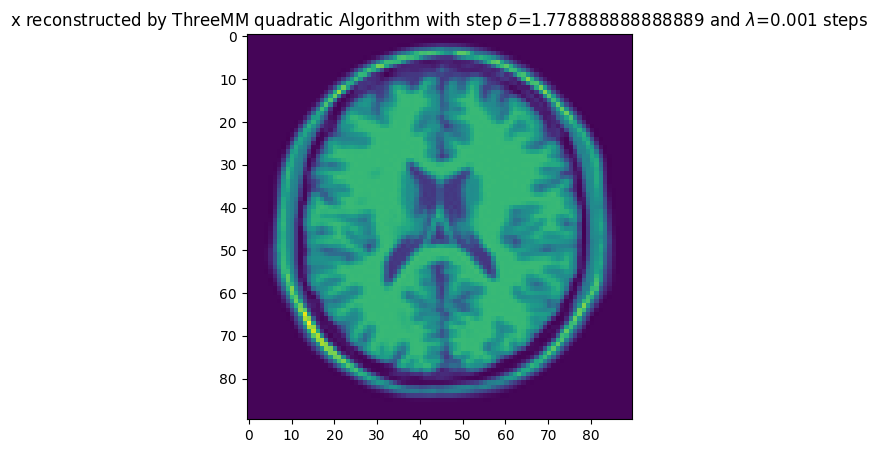

In [102]:
fig = plt.figure(figsize=(10,5))

plt.imshow(ThreeMMopti.x.reshape((90,90), order = 'F'))
plt.title(r"x reconstructed by ThreeMM quadratic Algorithm with step $\delta$={} and $\lambda$={} steps".format(ThreeMM.delta,  ThreeMM.lambd))

plt.show()

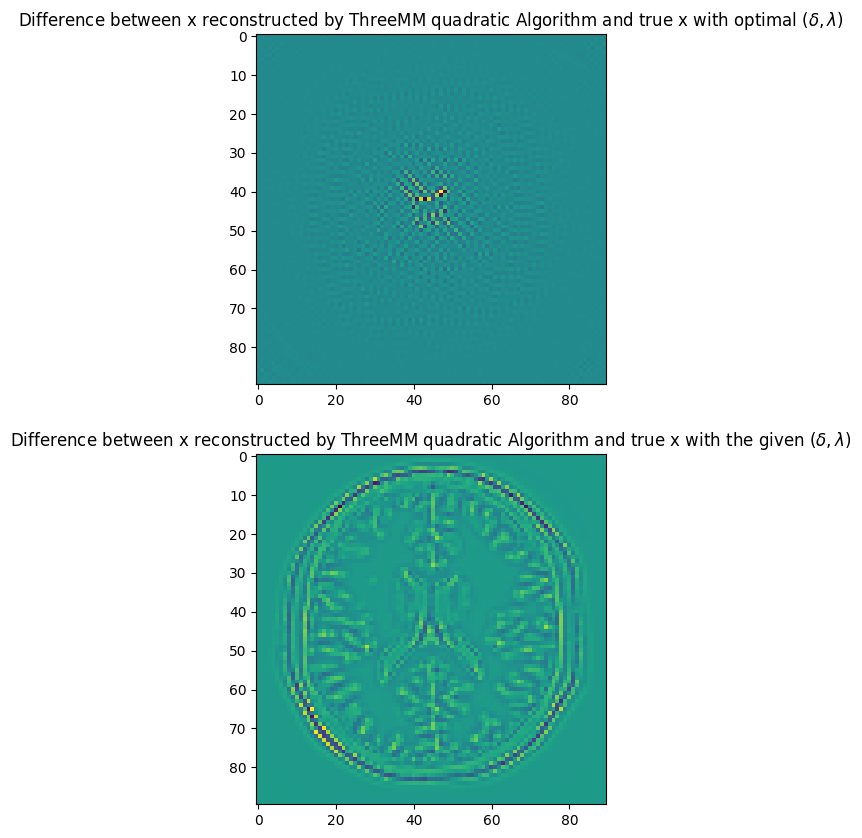

In [105]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(2,1,1)
plt.imshow((ThreeMMopti.x-x['x']).reshape((90,90), order = 'F'))
plt.title("Difference between x reconstructed by ThreeMM quadratic Algorithm and true x with optimal $(\delta,\lambda)$ ")
fig.add_subplot(2,1,2)
plt.imshow((ThreeMMorig.x-x['x']).reshape((90,90), order = 'F'))
plt.title("Difference between x reconstructed by ThreeMM quadratic Algorithm and true x with the given $(\delta,\lambda)$ ")

plt.show()

**More precise estimation of optimal $(\lambda, \delta)$**

In [112]:
lambda_test = np.linspace(0.0001, 0.001, 5)
delta_test = np.linspace(1.6, 2, 5)
snr = []
couples = []

for L in lambda_test:
    for D in delta_test:
        ThreeMM = MMMemoryGradientAlgorithmTest(lambda x:gradient_f_test(x,L, D), lambda x:compute_A_test(x, L, D), L, D)
        ThreeMM.train()
        p = SNR(x['x'], ThreeMM.x)
        snr.append(p)
        couples.append((L, D))
        print('λ = {:.5f}  \tδ = {:.5f}  SNR: {:.5f}'.format(L, D, p))
        print("f: ", ThreeMM.f_values[-1])
        print("quatradic error: ", ThreeMM.errors[-1])

 10%|████████████████▍                                                                                                                                                 | 1012/10000 [00:43<06:26, 23.23it/s]


λ = 0.00010  	δ = 1.60000  SNR: 49.16025
f:  1.6227329012303633
quatradic error:  0.12293842429855917


 10%|████████████████▏                                                                                                                                                 | 1000/10000 [00:40<06:07, 24.46it/s]


λ = 0.00010  	δ = 1.70000  SNR: 49.14283
f:  1.622425215336434
quatradic error:  0.12318532496531964


 10%|████████████████▍                                                                                                                                                 | 1012/10000 [00:42<06:14, 24.01it/s]


λ = 0.00010  	δ = 1.80000  SNR: 49.17613
f:  1.622166376055832
quatradic error:  0.12271391138101023


 10%|████████████████▏                                                                                                                                                  | 995/10000 [00:42<06:24, 23.40it/s]


λ = 0.00010  	δ = 1.90000  SNR: 49.13759
f:  1.621947998409433
quatradic error:  0.12325964985389157


 10%|███████████████▊                                                                                                                                                   | 969/10000 [00:45<06:59, 21.51it/s]


λ = 0.00010  	δ = 2.00000  SNR: 49.03993
f:  1.6217623618179815
quatradic error:  0.12465332958576698


 10%|████████████████▉                                                                                                                                                 | 1046/10000 [04:57<42:24,  3.52it/s]


λ = 0.00032  	δ = 1.60000  SNR: 49.23033
f:  5.27383308934067
quatradic error:  0.12195048210682266


 10%|████████████████▌                                                                                                                                                 | 1024/10000 [01:27<12:50, 11.65it/s]


λ = 0.00032  	δ = 1.70000  SNR: 49.16840
f:  5.272833184364204
quatradic error:  0.12282313644936982


 10%|████████████████▎                                                                                                                                               | 1021/10000 [11:50<1:44:06,  1.44it/s]


λ = 0.00032  	δ = 1.80000  SNR: 49.17264
f:  5.271993450419178
quatradic error:  0.12276315147880024


 10%|████████████████                                                                                                                                                 | 994/10000 [41:53<6:19:30,  2.53s/it]


λ = 0.00032  	δ = 1.90000  SNR: 49.07362
f:  5.271283405132088
quatradic error:  0.12417076771143742


 10%|████████████████▏                                                                                                                                               | 1013/10000 [49:35<7:19:53,  2.94s/it]


λ = 0.00032  	δ = 2.00000  SNR: 49.15376
f:  5.270674331202378
quatradic error:  0.12303031900102324


 10%|████████████████                                                                                                                                                | 1005/10000 [34:06<5:05:13,  2.04s/it]


λ = 0.00055  	δ = 1.60000  SNR: 49.06436
f:  8.924935763033345
quatradic error:  0.12430318047281251


 10%|███████████████▊                                                                                                                                             | 1006/10000 [1:15:21<11:13:40,  4.49s/it]


λ = 0.00055  	δ = 1.70000  SNR: 49.07980
f:  8.923242243360828
quatradic error:  0.12408239827999384


 10%|████████████████                                                                                                                                                | 1001/10000 [43:16<6:29:05,  2.59s/it]


λ = 0.00055  	δ = 1.80000  SNR: 49.06127
f:  8.92182161446895
quatradic error:  0.12434736725997465


 10%|████████████████▎                                                                                                                                               | 1021/10000 [16:16<2:23:07,  1.05it/s]


λ = 0.00055  	δ = 1.90000  SNR: 49.16504
f:  8.920616397371669
quatradic error:  0.12287069845909662


 10%|████████████████▍                                                                                                                                               | 1027/10000 [09:31<1:23:14,  1.80it/s]


λ = 0.00055  	δ = 2.00000  SNR: 49.18965
f:  8.919587283366603
quatradic error:  0.12252310245130488


 10%|████████████████▍                                                                                                                                                 | 1018/10000 [00:44<06:30, 23.03it/s]


λ = 0.00078  	δ = 1.60000  SNR: 49.09809
f:  12.57603536816707
quatradic error:  0.12382139111114825


 10%|████████████████▌                                                                                                                                                 | 1023/10000 [00:40<05:58, 25.06it/s]


λ = 0.00078  	δ = 1.70000  SNR: 49.13137
f:  12.5736490799766
quatradic error:  0.12334792072058233


 10%|████████████████▏                                                                                                                                                  | 991/10000 [00:39<05:58, 25.11it/s]


λ = 0.00078  	δ = 1.80000  SNR: 49.02251
f:  12.571648473851985
quatradic error:  0.12490347528424864


 10%|████████████████▏                                                                                                                                                 | 1002/10000 [00:39<05:54, 25.37it/s]


λ = 0.00078  	δ = 1.90000  SNR: 49.06231
f:  12.569951724048545
quatradic error:  0.1243325550651698


 10%|████████████████▋                                                                                                                                                 | 1027/10000 [00:40<05:50, 25.58it/s]


λ = 0.00078  	δ = 2.00000  SNR: 49.18820
f:  12.568500518316654
quatradic error:  0.1225435418954655


 10%|███████████████▊                                                                                                                                                   | 973/10000 [00:38<05:54, 25.48it/s]


λ = 0.00100  	δ = 1.60000  SNR: 48.91236
f:  16.227137413306707
quatradic error:  0.12649758786118304


 10%|████████████████▋                                                                                                                                                 | 1031/10000 [00:40<05:54, 25.30it/s]


λ = 0.00100  	δ = 1.70000  SNR: 49.15583
f:  16.224055964878378
quatradic error:  0.12300097539291702


 10%|████████████████▎                                                                                                                                                 | 1009/10000 [00:39<05:56, 25.25it/s]


λ = 0.00100  	δ = 1.80000  SNR: 49.08548
f:  16.221473693588596
quatradic error:  0.12400125966206711


 10%|████████████████▎                                                                                                                                                  | 997/10000 [00:38<05:51, 25.63it/s]


λ = 0.00100  	δ = 1.90000  SNR: 49.03579
f:  16.219285798746505
quatradic error:  0.1247126930459373


 10%|████████████████▏                                                                                                                                                 | 1001/10000 [00:39<05:57, 25.20it/s]

λ = 0.00100  	δ = 2.00000  SNR: 49.07814
f:  16.21741490721559
quatradic error:  0.12410617578940716


In [113]:
print('\033[1m' + "Best (lambda, delta):" + '\033[0m', couples[np.argmax(snr)])
print('\033[1m' + "Best SNR:" + '\033[0m', max(snr))

Best (lambda, delta): (0.000325, 1.6)
Best SNR: 49.23033497240134
